# Example: How to run PyRayHF
This example shows how to call PyRayHF for a given set of input arrays

Initial position (r, theta): [6371.    0.]
Initial direction (r̂, θ̂): [0.5       0.8660254]
Ne= 1178477260916.944
f0= 9000000.0
mup valid count: 447
mup min/max: 1.004194060598928 15.051912537460215
Max sin_theta_h: 0.49999999999999994


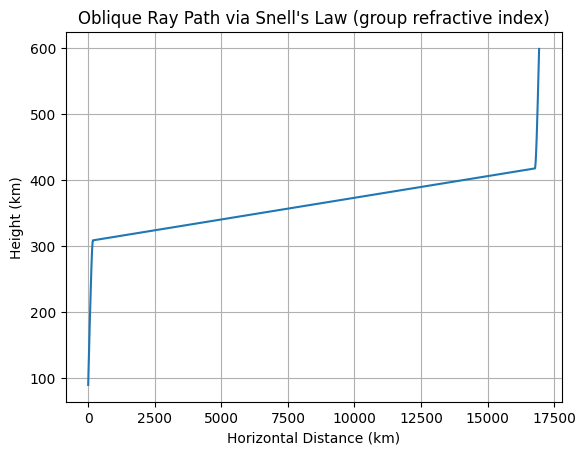

[0.00000000e+00 5.78037123e-01 1.15690183e+00 1.73676064e+00
 2.31780910e+00 2.90027468e+00 3.48441883e+00 4.07053742e+00
 4.65895863e+00 5.25003689e+00 5.84414130e+00 6.44163670e+00
 7.04285589e+00 7.64806219e+00 8.25740344e+00 8.87086119e+00
 9.48820282e+00 1.01089477e+01 1.07323599e+01 1.13574785e+01
 1.19831863e+01 1.26086163e+01 1.32331854e+01 1.38563545e+01
 1.44776507e+01 1.50966846e+01 1.57131593e+01 1.63268720e+01
 1.69377097e+01 1.75456398e+01 1.81506981e+01 1.87529757e+01
 1.93526052e+01 1.99497492e+01 2.05445887e+01 2.11373147e+01
 2.17316309e+01 2.23276020e+01 2.29252657e+01 2.35246576e+01
 2.41258107e+01 2.47287557e+01 2.53335206e+01 2.59401304e+01
 2.65486077e+01 2.71589720e+01 2.77712403e+01 2.83854265e+01
 2.90015419e+01 2.96195950e+01 3.02395919e+01 3.08615357e+01
 3.14854275e+01 3.21112659e+01 3.27390472e+01 3.33687658e+01
 3.40004140e+01 3.46339825e+01 3.52694603e+01 3.59068348e+01
 3.65460923e+01 3.71872178e+01 3.78301953e+01 3.84750078e+01
 3.91216377e+01 3.977006

In [ ]:
import pickle
import PyRayHF
import numpy as np
import matplotlib.pyplot as plt
from PyRayHF.library import find_X, find_Y, find_mu_mup

import numpy as np

# Constants
R_E = 6371.0  # Earth's radius in km
tx_height_km = 0.0
elev_angle_deg = 30.0
f0_MHz = 10.0


# See Example_Generate_Input_Arrays for how to create input arrays using PyIRI.
file_open = 'input_arrays_clean.npz'
input_arrays = np.load(file_open)


# Derived values
r0 = R_E + tx_height_km  # initial radial position from Earth's center
theta0_rad = np.radians(90.0 - elev_angle_deg)  # angle from zenith

# Initial direction unit vector in (r, theta) coordinates (spherical polar 2D)
# r̂ points radially outward, θ̂ is tangent to Earth's surface
ur = np.cos(theta0_rad)
utheta = np.sin(theta0_rad)

# Initial position and direction vector
initial_pos = np.array([r0, 0.0])        # [radius from Earth's center, angle along Earth's surface]
initial_dir = np.array([ur, utheta])     # unit direction vector

print("Initial position (r, theta):", initial_pos)
print("Initial direction (r̂, θ̂):", initial_dir)

# Load 1D ionospheric profile
data = np.load("input_arrays_clean.npz")
alt_km = data["alt"]
Ne = data["den"]
Babs = data["bmag"]
bpsi = data["bpsi"]
mode = "O"

print('Ne=', Ne.max())

# Frequency and elevation angle
f0 = 9.0 * 1e6
print('f0=', f0)
theta0_deg = 30.0  # zenith angle = 90° - elevation
theta0_rad = np.radians(theta0_deg)

# Compute plasma parameters
X = find_X(Ne, f0)
Y = find_Y(f0, Babs)

mu, mup = find_mu_mup(X, Y, bpsi, mode)

print("mup valid count:", np.sum(~np.isnan(mup)))
print("mup min/max:", np.nanmin(mup), np.nanmax(mup))

mup = np.where((mup < 1e-3) | np.isnan(mup), np.nan, mup)
mup0 = mup[0]

sin_theta_h = (mup0 / mup) * np.sin(theta0_rad)
print("Max sin_theta_h:", np.nanmax(sin_theta_h))

# Apply Snell's law to compute bending
with np.errstate(invalid='ignore'):
    sin_theta_h = (mup / mup0) * np.sin(theta0_rad)
    theta_h = np.arcsin(sin_theta_h)
    tan_theta_h = np.tan(theta_h)

# Horizontal distance integration
dx = np.zeros_like(alt_km)
# Valid values: must be finite and real
valid = ~np.isnan(tan_theta_h)

# Apply mask to both altitudes and angles
alt_valid = alt_km[valid]
tan_valid = tan_theta_h[valid]

# Compute horizontal increments
dx_valid = np.zeros_like(alt_valid)
dx_valid[1:] = np.cumsum(np.diff(alt_valid) * tan_valid[1:])

# Plot using only valid points
plt.plot(dx_valid, alt_valid)
plt.xlabel("Horizontal Distance (km)")
plt.ylabel("Height (km)")
plt.title("Oblique Ray Path via Snell's Law (group refractive index)")
plt.grid()
plt.show()

